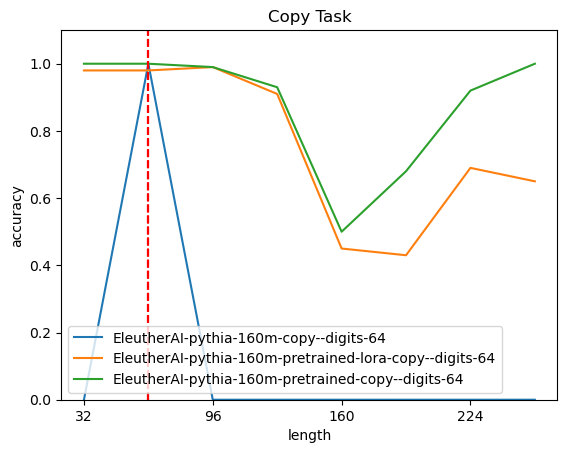

In [10]:
import wandb
import json

api = wandb.Api()
runs = api.runs('jackcai1206/mamba-arithmetic', filters={
    'config.model_id': 'EleutherAI/pythia-160m',
    'config.op': 'copy',
    'State': 'finished'
})[:3]

for run in runs:
    config = run.config
    lengths = range(config['n_digits_eval_start'], config['n_digits_eval_end'] + 1, config['n_digits_eval_step'])
    accs = []
    for l in lengths:
        accs.append(run.summary[f'eval/{l}_accuracy'])

    from matplotlib import pyplot as plt
    plt.plot(lengths, accs, label=config['run_name'])
    plt.vlines(config['n_digits_train'], 0, 1.1, linestyles='dashed', colors='r')
    plt.xticks(lengths[::2])
    plt.xlabel('length')
    plt.ylim(0, 1.1)
    plt.ylabel('accuracy')
plt.title('Copy Task')
plt.legend()


{'_runtime': 32326.707334280018, '_step': 2949, '_timestamp': 1724825629.1533692, '_wandb': {'runtime': 32326}, 'eval/12-add-reverse-carry-only_accuracy': 1, 'eval/12-add-reverse-carry-only_distance': 1, 'eval/12-add-reverse-carry-only_runtime': 0.7897, 'eval/12-add-reverse-carry-only_samples_per_second': 126.629, 'eval/12-add-reverse-carry-only_steps_per_second': 1.266, 'eval/12-add-reverse-no-carry_accuracy': 1, 'eval/12-add-reverse-no-carry_distance': 1, 'eval/12-add-reverse-no-carry_runtime': 0.777, 'eval/12-add-reverse-no-carry_samples_per_second': 128.696, 'eval/12-add-reverse-no-carry_steps_per_second': 1.287, 'eval/12-add-reverse_accuracy': 1, 'eval/12-add-reverse_distance': 1, 'eval/12-add-reverse_runtime': 0.7926, 'eval/12-add-reverse_samples_per_second': 126.161, 'eval/12-add-reverse_steps_per_second': 1.262, 'eval/16-add-reverse-carry-only_accuracy': 1, 'eval/16-add-reverse-carry-only_distance': 1, 'eval/16-add-reverse-carry-only_runtime': 0.8174, 'eval/16-add-reverse-carry

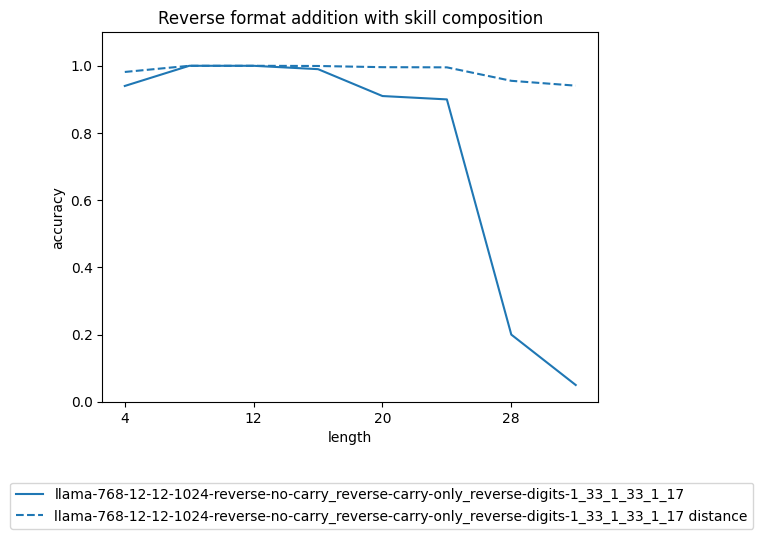

In [12]:
import wandb
import json
import seaborn as sns

api = wandb.Api()
runs = api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': {'$in': ['xvvj9lxa', ]},
})[:2]

for ri, run in enumerate(runs):
    config = run.config
    lengths = range(*config['n_digits_eval'])
    accs = []
    dists = []
    print(run.summary)
    for l in lengths:
        accs.append(run.summary[f'eval/{l}-add-reverse_accuracy'])
        dists.append(run.summary[f'eval/{l}-add-reverse_distance'])

    from matplotlib import pyplot as plt
    plt.plot(lengths, accs, label=config['run_name'], color=sns.color_palette()[ri])
    plt.plot(lengths, dists, label=config['run_name'] + ' distance', linestyle='--', color=sns.color_palette()[ri])
    # plt.vlines(config['n_digits_train'][1], 0, 1.1, linestyles='dashed', colors='r')
    plt.xticks(lengths[::2])
    plt.xlabel('length')
    plt.ylim(0, 1.1)
    plt.ylabel('accuracy')
plt.title('Reverse format addition with skill composition')
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.2))

6600.0
13400.0
10800.0
7800.0
15000.0
10000.0
10000.0
9200.0
11600.0


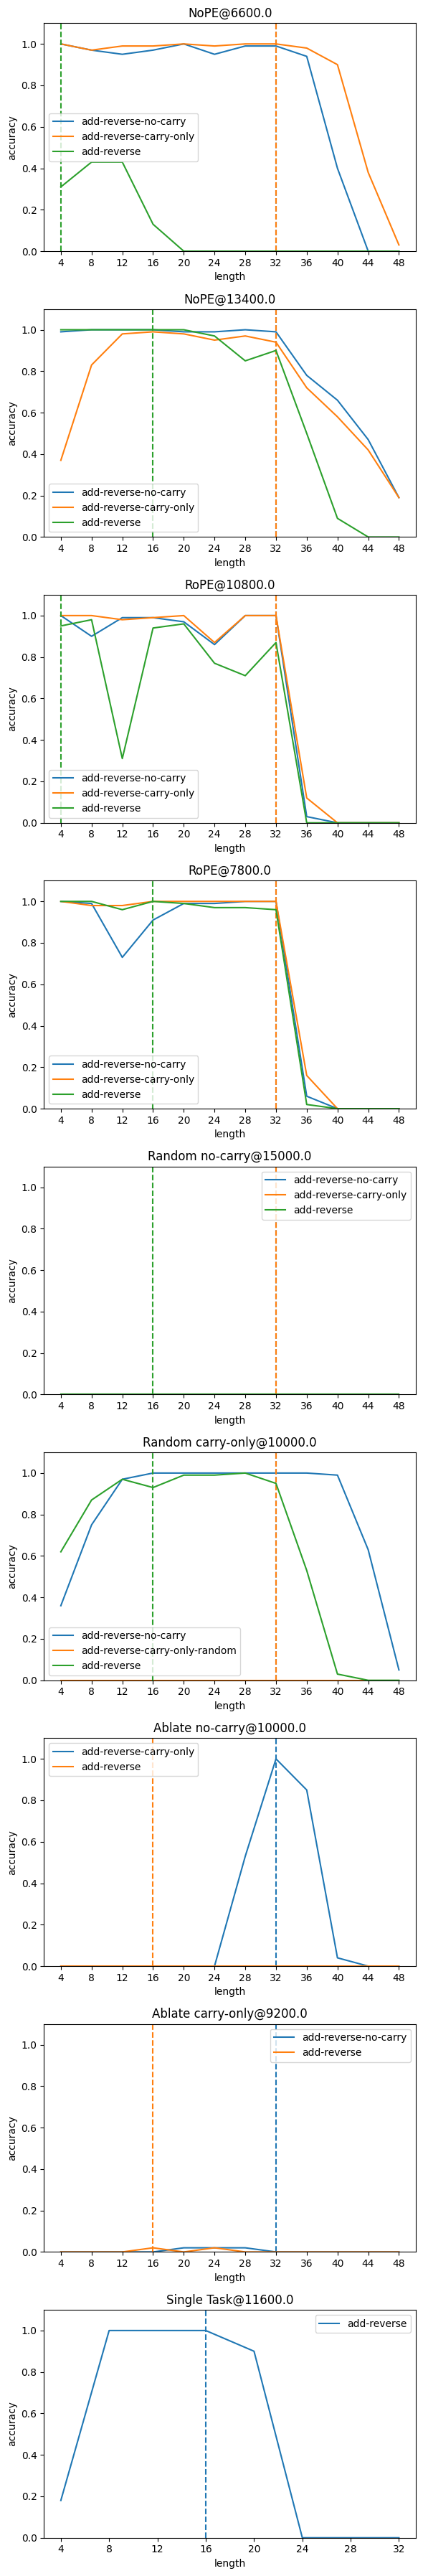

In [11]:
import wandb
import json
import seaborn as sns
from matplotlib import pyplot as plt

api = wandb.Api()
runs = api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': 'wbsr57o4', # NoPE
})[:1] + \
api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': 'abmimwgj', # NoPE
})[:1] + \
api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': '18gt2aq2', # RoPE
})[:1] + \
api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': 'lwfgmjuh', # RoPE
})[:1] + \
api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': 'l5xwfi1m', # Random no-carry
})[:1] + \
api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': 'wo1rfytr', # Random carry-only
})[:1] + \
api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': '5w6rqgn6', # Ablate no-carry
})[:1] + \
api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': '545zx6gn', # Ablate carry-only
})[:1] + \
api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': 'blnk1myn', # Single Task
})[:1]

names = ['NoPE', 'NoPE', 'RoPE', 'RoPE', 'Random no-carry', 'Random carry-only', 'Ablate no-carry', 'Ablate carry-only', 'Single Task']
pick_step = []

fig, axes = plt.subplots(len(runs), 1, figsize=(6, 4 * len(runs),))
for i, (run, name) in enumerate(zip(runs, names)):
    config = run.config
    lengths = range(*config['n_digits_eval'])

    keys = []
    for j, (op, format, n_digits_train) in enumerate(zip(config['op_eval'], config['format_eval'], config['n_digits_train'])):
        for l in lengths:
            keys.append(f'eval/{l}-{op}-{format}_accuracy')
    history = run.history(samples=5000, x_axis='train/global_step')
    # history = history.groupby('train/global_step').apply(lambda df: df.ffill().bfill().iloc[0])
    # print(history)
    history = history.ffill().bfill()[::-1]
    history['sum'] = history[['eval/32-add-reverse_accuracy', 'eval/16-add-reverse_accuracy', 'eval/8-add-reverse_accuracy']].sum(axis=1)
    max_index = history['sum'].idxmax()
    # max_index = history['eval/32-add-reverse_accuracy'].idxmax()
    record = history.loc[max_index]
    print(record['train/global_step'])
    # record = run.summary
    # print(name, record)

    for j, (op, format, n_digits_train) in enumerate(zip(config['op_eval'], config['format_eval'], config['n_digits_train'])):
        train_range = list(range(*n_digits_train))
        accs = []
        for l in lengths:
            accs.append(record[f'eval/{l}-{op}-{format}_accuracy'])

        c = sns.color_palette()[j]
        axes[i].plot(lengths, accs, color=c, label=f'{op}-{format}')
        axes[i].vlines(train_range[-1], 0, 1.1, linestyles='dashed', colors=c)
        # axes[i].axvspan(train_range[0], train_range[-1], color='blue', alpha=0.3)
    axes[i].set_xticks(lengths)
    axes[i].set_xlabel('length')
    axes[i].set_ylim(0, 1.1)
    axes[i].set_ylabel('accuracy')
    axes[i].set_title(name + '@' + str(record['train/global_step']))
    axes[i].legend()

plt.tight_layout()
plt.show()


NoPE {'_runtime': 45542.67520189285, '_step': 8201, '_timestamp': 1725991899.723311, '_wandb': {'runtime': 45542}, 'eval/12-add-automata_A_accuracy': 0.53, 'eval/12-add-automata_A_distance': 0.9620408163265308, 'eval/12-add-automata_A_runtime': 1.031, 'eval/12-add-automata_A_samples_per_second': 96.993, 'eval/12-add-automata_A_steps_per_second': 0.97, 'eval/12-add-automata_B_accuracy': 0.34, 'eval/12-add-automata_B_distance': 0.9197959183673468, 'eval/12-add-automata_B_runtime': 1.0261, 'eval/12-add-automata_B_samples_per_second': 97.458, 'eval/12-add-automata_B_steps_per_second': 0.975, 'eval/12-add-automata_C_accuracy': 0.13, 'eval/12-add-automata_C_distance': 0.8683673469387756, 'eval/12-add-automata_C_runtime': 1.0301, 'eval/12-add-automata_C_samples_per_second': 97.073, 'eval/12-add-automata_C_steps_per_second': 0.971, 'eval/16-add-automata_A_accuracy': 0.64, 'eval/16-add-automata_A_distance': 0.975076923076923, 'eval/16-add-automata_A_runtime': 1.2325, 'eval/16-add-automata_A_sam

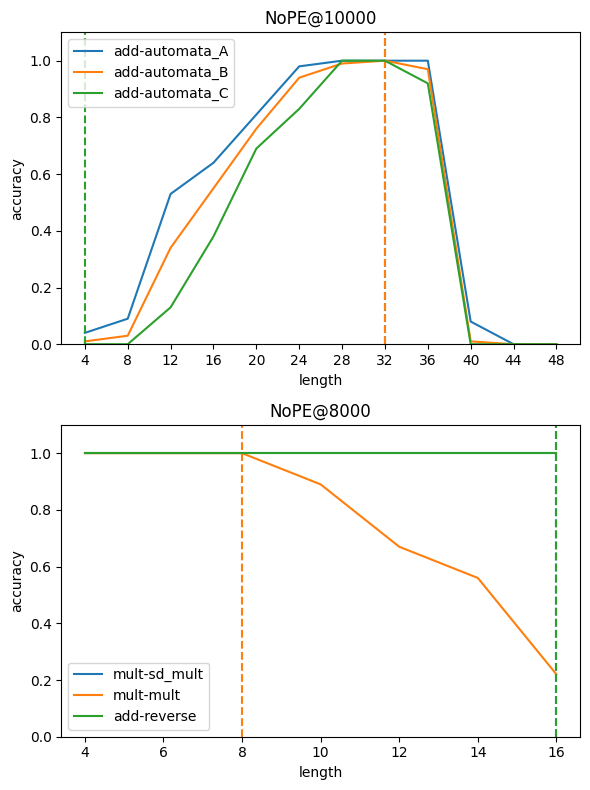

In [4]:
import wandb
import json
import seaborn as sns
from matplotlib import pyplot as plt

api = wandb.Api()
runs = api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': '8rpnuerl', # NoPE
})[:1] + \
api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': '6j4kf70a', # NoPE
})[:1]
names = ['NoPE', 'NoPE']
pick_step = []

fig, axes = plt.subplots(len(runs), 1, figsize=(6, 4 * len(runs),))
if len(runs) == 1:
    axes = [axes]
for i, (run, name) in enumerate(zip(runs, names)):
    config = run.config
    lengths = range(*config['n_digits_eval'])

    keys = []
    for j, (op, format, n_digits_train) in enumerate(zip(config['op_eval'], config['format_eval'], config['n_digits_train'])):
        for l in lengths:
            keys.append(f'eval/{l}-{op}-{format}_accuracy')
    history = run.history(samples=5000, x_axis='train/global_step')
    # history = history.groupby('train/global_step').apply(lambda df: df.ffill().bfill().iloc[0])
    # print(history)
    # history = history.ffill().bfill()[::-1]
    # history['sum'] = history[['eval/32-add-reverse_accuracy', 'eval/16-add-reverse_accuracy', 'eval/8-add-reverse_accuracy']].sum(axis=1)
    # max_index = history['sum'].idxmax()
    # # max_index = history['eval/32-add-reverse_accuracy'].idxmax()
    # record = history.loc[max_index]
    # print(record['train/global_step'])
    record = run.summary
    print(name, record)

    for j, (op, format, n_digits_train) in enumerate(zip(config['op_eval'], config['format_eval'], config['n_digits_train'])):
        train_range = list(range(*n_digits_train))
        accs = []
        for l in lengths:
            accs.append(record[f'eval/{l}-{op}-{format}_accuracy'])

        c = sns.color_palette()[j]
        axes[i].plot(lengths, accs, color=c, label=f'{op}-{format}')
        axes[i].vlines(train_range[-1], 0, 1.1, linestyles='dashed', colors=c)
        # axes[i].axvspan(train_range[0], train_range[-1], color='blue', alpha=0.3)
    axes[i].set_xticks(lengths)
    axes[i].set_xlabel('length')
    axes[i].set_ylim(0, 1.1)
    axes[i].set_ylabel('accuracy')
    axes[i].set_title(name + '@' + str(record['train/global_step']))
    axes[i].legend()

plt.tight_layout()
plt.show()
